In [1]:
from src.data_preprocessor import DataProcessor
from data_configs.configs import *
from models.neural_networks import *
from src.cross_validation import CrossValidation
import numpy as np

config = machine_config
data_processor = DataProcessor(config=config)
cross_validator = CrossValidation(config=config)

In [2]:
raw_data = data_processor.load_data()
data_1 = raw_data.drop(columns=['vendor_name','model_name','ERP'])
data_2 = data_processor.impute_missing_values(data_1)
data_3 = data_processor.standardize_data(data_2,data_2,features=['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX'])


c:\Users\Srikanta\Documents\Intro to Machine Learning\programming_assignment_1\src\data_preprocessor.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mean(), inplace=True)


In [3]:
data_3

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
0,-0.302859,-0.673409,-0.494275,5.680569,1.658008,4.220899,198
1,-0.671717,1.323114,1.722913,0.167228,0.484346,0.528211,269
2,-0.671717,1.323114,1.722913,0.167228,0.484346,0.528211,220
3,-0.671717,1.323114,1.722913,0.167228,0.484346,0.528211,172
4,-0.671717,1.323114,0.358489,0.167228,0.484346,-0.087238,132
...,...,...,...,...,...,...,...
204,-0.306701,-0.481594,-0.323723,-0.620392,-0.542608,-0.394962,42
205,-0.406600,-0.481594,-0.323723,0.167228,-0.395900,-0.394962,46
206,-0.302859,-0.223779,-0.323723,-0.620392,-0.395900,-0.164169,52
207,1.061146,-0.607408,-0.323723,0.167228,-0.689316,-0.702686,67


In [4]:
data_train, data_val = cross_validator.random_partition(data_3, random_state=42)

In [5]:
data = data_train.to_numpy()
X_train = data[:,:-1]
y_train = data[:,-1:]

In [6]:
data_test = data_val.to_numpy()
X_val = data_test[:,:-1]
y_val = data_test[:,-1:]

In [7]:
autoE = AutoEncoder(config,n_input=X_train.shape[1],n_encoder=4)

autoE.train(X_train, max_epochs=30000, lr=0.0001)

Epoch 0/30000, Loss: 0.8717322544458517
Epoch 1/30000, Loss: 0.8716320604233109
Epoch 2/30000, Loss: 0.8715385351603133
Epoch 3/30000, Loss: 0.8714512247267311
Epoch 4/30000, Loss: 0.8713697062378181
Epoch 5/30000, Loss: 0.8712935857246745
Epoch 6/30000, Loss: 0.8712224961512134
Epoch 7/30000, Loss: 0.8711560955675048
Epoch 8/30000, Loss: 0.8710940653900767
Epoch 9/30000, Loss: 0.8710361088004098
Epoch 10/30000, Loss: 0.8709819492534715
Epoch 11/30000, Loss: 0.8709313290886963
Epoch 12/30000, Loss: 0.8708840082363563
Epoch 13/30000, Loss: 0.8708397630127424
Epoch 14/30000, Loss: 0.8707983849980444
Epoch 15/30000, Loss: 0.8707596799912325
Epoch 16/30000, Loss: 0.8707234670366409
Epoch 17/30000, Loss: 0.8706895775173226
Epoch 18/30000, Loss: 0.8706578543105782
Epoch 19/30000, Loss: 0.8706281510013879
Epoch 20/30000, Loss: 0.8706003311497633
Epoch 21/30000, Loss: 0.8705742676083159
Epoch 22/30000, Loss: 0.8705498418865889
Epoch 23/30000, Loss: 0.8705269435589447
Epoch 24/30000, Loss: 0.87

In [8]:
combined = CombinedModel(autoE,n_hidden_2=100,n_output=1)

MSEs, val_metrics, final_mse = combined.train(X_train,y_train,X_val,y_val,epochs=10000,lr=0.000001)

Epoch 0/10000, Train MSE: 29110.31301343489, Val MSE: 67844.70463677606
Epoch 100/10000, Train MSE: 28708.08163460751, Val MSE: 67321.03651646477
Epoch 200/10000, Train MSE: 24240.874451532123, Val MSE: 60970.91908142093
Epoch 300/10000, Train MSE: 17067.802753514086, Val MSE: 49661.46659518846
Epoch 400/10000, Train MSE: 13606.609271094674, Val MSE: 43553.348323843464
Epoch 500/10000, Train MSE: 11297.858990206556, Val MSE: 38863.65647902218
Epoch 600/10000, Train MSE: 9855.250235012792, Val MSE: 35393.09466630972
Epoch 700/10000, Train MSE: 8822.049916817698, Val MSE: 32688.301621699655
Epoch 800/10000, Train MSE: 8076.479293030611, Val MSE: 30540.395597117913
Epoch 900/10000, Train MSE: 7515.770407713542, Val MSE: 28762.029469433062
Epoch 1000/10000, Train MSE: 7055.222474630211, Val MSE: 27229.149065978476
Epoch 1100/10000, Train MSE: 6503.487066450703, Val MSE: 25793.413323004304
Epoch 1200/10000, Train MSE: 5997.434001371552, Val MSE: 24511.11009928696
Epoch 1300/10000, Train MSE

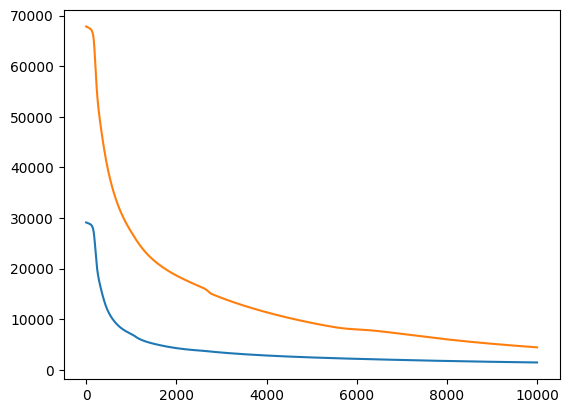

In [9]:
import matplotlib.pyplot as plt

plt.plot(MSEs)
plt.plot(val_metrics)

In [10]:
ffn = FeedForwardNetwork(config,n_input=X_train.shape[1],n_hidden_1=100,n_hidden_2=100,n_output=1)

MSEs, val_metrics, final_mse = ffn.train(X_train,y_train,X_val,y_val,5000,0.000001)

Epoch 0/5000, Train MSE: 29110.310109685048, Val MSE: 67843.1606542855
Epoch 100/5000, Train MSE: 28573.528649534244, Val MSE: 66992.582696384
Epoch 200/5000, Train MSE: 17875.570972678743, Val MSE: 51333.619640386554
Epoch 300/5000, Train MSE: 13522.175386914334, Val MSE: 43375.20605053459
Epoch 400/5000, Train MSE: 11412.596919369216, Val MSE: 38751.148401587256
Epoch 500/5000, Train MSE: 10098.867593438354, Val MSE: 35537.46787088908
Epoch 600/5000, Train MSE: 9198.246943745426, Val MSE: 33123.963363777286
Epoch 700/5000, Train MSE: 8632.597754896287, Val MSE: 31463.837409398304
Epoch 800/5000, Train MSE: 8303.193268105493, Val MSE: 30232.722698610425
Epoch 900/5000, Train MSE: 8000.017457025477, Val MSE: 29145.678068223006
Epoch 1000/5000, Train MSE: 7695.871747981535, Val MSE: 28149.51097096703
Epoch 1100/5000, Train MSE: 7458.543114244488, Val MSE: 27311.258353196394
Epoch 1200/5000, Train MSE: 7250.0488041742865, Val MSE: 26567.059385577268
Epoch 1300/5000, Train MSE: 7061.13696

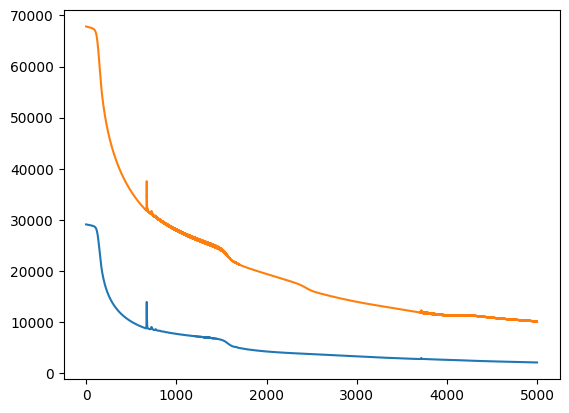

In [11]:
import matplotlib.pyplot as plt

plt.plot(MSEs)
plt.plot(val_metrics)

In [12]:
linear = LinearNetwork(config)

losses = linear.linear_regression(X_train,y_train,X_val,y_val)

Epoch 0/1000, Training MSE: 29112.187353724625, Validation MSE: 63408.729404031365
Epoch 100/1000, Training MSE: 3556.0587830660074, Validation MSE: 7197.064279952782
Epoch 200/1000, Training MSE: 3161.432869334319, Validation MSE: 5920.6128751809665
Epoch 300/1000, Training MSE: 3126.4001992189374, Validation MSE: 5693.792700727994
Epoch 400/1000, Training MSE: 3119.794751412315, Validation MSE: 5639.412883601773
Epoch 500/1000, Training MSE: 3118.232209207385, Validation MSE: 5626.068044289491
Epoch 600/1000, Training MSE: 3117.8258304200845, Validation MSE: 5623.75402647198
Epoch 700/1000, Training MSE: 3117.7122554930324, Validation MSE: 5624.499931367264
Epoch 800/1000, Training MSE: 3117.677975614682, Validation MSE: 5625.972028118589
Epoch 900/1000, Training MSE: 3117.6665970736362, Validation MSE: 5627.450828742144
